In [ ]:
print("\n===== BƯỚC 1: IMPORT CÁC THƯ VIỆN CẦN THIẾT =====")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import requests
from io import BytesIO
import timm
import torchvision.transforms as transforms
import random
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
print("Đã import tất cả thư viện cần thiết.")

In [ ]:
print("\n===== BƯỚC 2: ĐỌC VÀ KHÁM PHÁ DỮ LIỆU =====")
df = pd.read_csv('Data_Clean.csv')

print("Kích thước dữ liệu:", df.shape)
print("\nThông tin dữ liệu:")
print(df.info())
print("\nThống kê mô tả:")
print(df.describe())
print("\n5 dòng đầu tiên:")
print(df.head())

In [ ]:
print("\n===== BƯỚC 3: TIỀN XỬ LÝ DỮ LIỆU =====")
print("Số lượng giá trị null trong mỗi cột:")
print(df.isnull().sum())

df = df.dropna(subset=['thumbnail_url', 'price', 'rating_average'])  
print(f"Kích thước dữ liệu sau khi xử lý giá trị null: {df.shape}")

df['discount_percentage'] = (df['original_price'] - df['price']) / df['original_price'] * 100
df['price_per_rating'] = df['price'] / (df['rating_average'] + 1) 
print("Đã tạo các tính năng mới: discount_percentage, price_per_rating")

print("\nPhân phối của các tính năng số:")
numeric_columns = ['price', 'original_price', 'discount', 'rating_average', 'review_count', 'quantity_sold']
df[numeric_columns].hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.savefig('numeric_features_distribution.png')
print("Đã lưu biểu đồ phân phối tính năng vào 'numeric_features_distribution.png'")

In [ ]:
print("\n===== BƯỚC 4: TẠO LỚP DATASET ĐỂ XỬ LÝ DỮ LIỆU SỐ VÀ HÌNH ẢNH =====")
class ProductDataset(Dataset):
    def __init__(self, dataframe, image_column, transform=None):
        self.dataframe = dataframe
        self.image_column = image_column
        self.transform = transform
        
        self.numeric_features = self.dataframe[['price', 'original_price', 'discount', 
                                               'rating_average', 'review_count', 
                                               'quantity_sold', 'discount_percentage']].values
        
        self.scaler = StandardScaler()
        self.numeric_features = self.scaler.fit_transform(self.numeric_features)
        
        if not os.path.exists('image_cache'):
            os.makedirs('image_cache')
        
        print(f"Đã khởi tạo ProductDataset với {len(dataframe)} mẫu và {self.numeric_features.shape[1]} tính năng số")
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        numeric_features = torch.tensor(self.numeric_features[idx], dtype=torch.float32)
        
        img_url = self.dataframe.iloc[idx][self.image_column]
        img_filename = f"image_cache/{self.dataframe.iloc[idx]['id']}.jpg"
        
        if os.path.exists(img_filename):
            img = Image.open(img_filename).convert('RGB')
        else:
            try:
                response = requests.get(img_url)
                img = Image.open(BytesIO(response.content)).convert('RGB')
                img.save(img_filename)  
            except:
                img = Image.new('RGB', (224, 224), color='white')
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(self.dataframe.iloc[idx]['price'], dtype=torch.float32)
        
        return numeric_features, img, label, idx

print("Đã định nghĩa lớp ProductDataset để xử lý cả dữ liệu số và hình ảnh")


In [ ]:
print("\n===== BƯỚC 5: XÂY DỰNG MÔ HÌNH KẾT HỢP VISION TRANSFORMER VÀ TÍNH NĂNG SỐ =====")
class HybridRecommendationModel(nn.Module):
    def __init__(self, num_numeric_features=7):
        super(HybridRecommendationModel, self).__init__()
        
        # Mô hình Vision Transformer cho ảnh
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.vit_feature_dim = self.vit.head.in_features
        self.vit.head = nn.Identity()  
        
        # Mạng neural cho tính năng số
        self.numeric_network = nn.Sequential(
            nn.Linear(num_numeric_features, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )
        
        # Kết hợp 
        self.combined_dim = self.vit_feature_dim + 128
        
        self.predictor = nn.Sequential(
            nn.Linear(self.combined_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, numeric_features, images):
        image_features = self.vit(images)
        
        numeric_features = self.numeric_network(numeric_features)
        
        combined_features = torch.cat((image_features, numeric_features), dim=1)
        
        output = self.predictor(combined_features)
        
        return output

print("Đã định nghĩa mô hình HybridRecommendationModel kết hợp Vision Transformer và tính năng số")

In [ ]:
print("\n===== BƯỚC 6: XÂY DỰNG THUẬT TOÁN MULTI-ARMED BANDITS (MAB) =====")
class EpsilonGreedyMAB:
    def __init__(self, num_arms, epsilon=0.1):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.values = np.zeros(num_arms)
        self.counts = np.zeros(num_arms)
        print(f"Đã khởi tạo EpsilonGreedyMAB với {num_arms} arms và epsilon = {epsilon}")
    
    def select_arm(self):
        if random.random() < self.epsilon:
            return random.randint(0, self.num_arms - 1)
        else:
            return np.argmax(self.values)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[arm] = new_value

print("Đã định nghĩa lớp EpsilonGreedyMAB để triển khai thuật toán Multi-Armed Bandits")

In [ ]:
print("\n===== BƯỚC 7: THIẾT LẬP QUY TRÌNH HUẤN LUYỆN =====")
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Sử dụng thiết bị: {device}")
    
    model = model.to(device)
    best_val_loss = float('inf')
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for numeric, images, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            numeric, images, labels = numeric.to(device), images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(numeric, images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * numeric.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for numeric, images, labels, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                numeric, images, labels = numeric.to(device), images.to(device), labels.to(device)
                
                outputs = model(numeric, images)
                loss = criterion(outputs.squeeze(), labels)
                
                val_loss += loss.item() * numeric.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_hybrid_model.pth')
            print(f"Đã lưu mô hình tốt nhất với Val Loss: {val_loss:.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig('training_history.png')
    print("Đã lưu biểu đồ quá trình huấn luyện vào 'training_history.png'")
    
    return model

print("Đã định nghĩa hàm train_model để huấn luyện mô hình")

In [ ]:
print("\n===== BƯỚC 8: XÂY DỰNG HÀM ĐÁNH GIÁ VÀ SO SÁNH CÁC MÔ HÌNH =====")
def evaluate_recommendations(model, test_loader, mab_bandit=None, use_mab=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_idx = []
    
    print(f"Đánh giá mô hình {'với MAB' if use_mab else 'không có MAB'}...")
    
    with torch.no_grad():
        for numeric, images, labels, idx in tqdm(test_loader, desc="Testing"):
            numeric, images = numeric.to(device), images.to(device)
            
            if use_mab and mab_bandit:
                arm = mab_bandit.select_arm()
                if arm == 0: 
                    outputs = model(numeric, images)
                    predictions = outputs.squeeze().cpu().numpy()
                else:  
                    predictions = np.random.rand(len(labels)) * labels.max().item()
                
                rewards = 1.0 / (1.0 + np.abs(predictions - labels.numpy()))
                for i, reward in enumerate(rewards):
                    mab_bandit.update(arm, reward)
            else:
                outputs = model(numeric, images)
                predictions = outputs.squeeze().cpu().numpy()
            
            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())
            all_idx.extend(idx.numpy())
    
    mse = mean_squared_error(all_labels, all_predictions)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    
    df_results = pd.DataFrame({
        'idx': all_idx,
        'true_value': all_labels,
        'predicted': all_predictions
    })
    
    return df_results, rmse

class ContentBasedModel:
    def __init__(self):
        self.scaler = StandardScaler()
        print("Đã khởi tạo ContentBasedModel")
    
    def fit(self, features, labels):
        self.features = self.scaler.fit_transform(features)
        self.labels = labels
        print(f"Đã huấn luyện ContentBasedModel với {len(features)} mẫu")
    
    def predict(self, features):
        features = self.scaler.transform(features)
        similarities = features @ self.features.T
        predictions = np.zeros(len(features))
        
        for i in range(len(features)):
            top_similar = np.argsort(similarities[i])[-5:]
            predictions[i] = np.mean(np.array(self.labels)[top_similar])
        
        print(f"Đã dự đoán {len(features)} mẫu với ContentBasedModel")
        return predictions

print("Đã định nghĩa hàm evaluate_recommendations và lớp ContentBasedModel")

In [ ]:
print("\n===== BƯỚC 9: THIẾT LẬP MAIN PIPELINE =====")
def main():
    print("Bắt đầu quy trình chính...")
    
    df = pd.read_csv('Data_Clean.csv')
    print(f"Đã đọc dữ liệu với {len(df)} mẫu")
    
    df = df.dropna(subset=['thumbnail_url', 'price', 'rating_average'])
    df['discount_percentage'] = (df['original_price'] - df['price']) / df['original_price'] * 100
    df['price_per_rating'] = df['price'] / (df['rating_average'] + 1)
    print(f"Dữ liệu sau khi xử lý: {len(df)} mẫu")
    
    if len(df) > 1000: #mẫu test
        df = df.sample(1000, random_state=42)
        print(f"Giới hạn dữ liệu còn {len(df)} mẫu để thử nghiệm nhanh hơn")
    
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    
    print(f"Chia dữ liệu thành: Train set: {len(train_df)}, Validation set: {len(val_df)}, Test set: {len(test_df)}")
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    print("Đã định nghĩa biến đổi cho ảnh")
    
    print("Đang tạo bộ dữ liệu...")
    train_dataset = ProductDataset(train_df, 'thumbnail_url', transform=transform)
    val_dataset = ProductDataset(val_df, 'thumbnail_url', transform=transform)
    test_dataset = ProductDataset(test_df, 'thumbnail_url', transform=transform)
    
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    print(f"Đã tạo DataLoader với batch size {batch_size}")
    
    print("Khởi tạo mô hình hybrid ViT + Neural Network...")
    hybrid_model = HybridRecommendationModel()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(hybrid_model.parameters(), lr=0.001)
    print("Đã định nghĩa loss function (MSE) và optimizer (Adam)")
    
    print("\n----- Huấn luyện mô hình Hybrid ViT + Neural Network -----")
    hybrid_model = train_model(hybrid_model, train_loader, val_loader, criterion, optimizer, num_epochs=1)
    
    mab_bandit = EpsilonGreedyMAB(num_arms=2, epsilon=0.1)
    
    print("\n----- Đánh giá mô hình Hybrid với MAB -----")
    hybrid_mab_results, hybrid_mab_rmse = evaluate_recommendations(
        hybrid_model, test_loader, mab_bandit=mab_bandit, use_mab=True
    )
    
    print("\n----- Đánh giá mô hình Hybrid thông thường -----")
    hybrid_results, hybrid_rmse = evaluate_recommendations(
        hybrid_model, test_loader, use_mab=False
    )
    
    print("\n----- Huấn luyện mô hình Content-Based để so sánh -----")
    train_features = train_dataset.numeric_features
    train_labels = train_df['price'].values
    
    test_features = test_dataset.numeric_features
    test_labels = test_df['price'].values
    
    content_model = ContentBasedModel()
    content_model.fit(train_features, train_labels)
    content_predictions = content_model.predict(test_features)
    
    content_rmse = np.sqrt(mean_squared_error(test_labels, content_predictions))
    print(f"Content-Based Model RMSE: {content_rmse:.4f}")
    
    print("\n===== KẾT QUẢ SO SÁNH CÁC MÔ HÌNH =====")
    print(f"Hybrid ViT + Neural Network + MAB RMSE: {hybrid_mab_rmse:.4f}")
    print(f"Hybrid ViT + Neural Network RMSE: {hybrid_rmse:.4f}")
    print(f"Content-Based Model RMSE: {content_rmse:.4f}")
    
    models = ['ViT+NN+MAB', 'ViT+NN', 'Content-Based']
    rmse_values = [hybrid_mab_rmse, hybrid_rmse, content_rmse]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, rmse_values, color=['green', 'blue', 'orange'])
    plt.title('So sánh các mô hình - RMSE (Giá trị thấp hơn là tốt hơn)')
    plt.ylabel('RMSE')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')
    
    plt.savefig('model_comparison.png')
    plt.show()
    print("Đã lưu biểu đồ so sánh vào 'model_comparison.png'")
    
    print("\n===== PHÂN TÍCH CÁC ĐỀ XUẤT =====")
    hybrid_mab_results['abs_error'] = abs(hybrid_mab_results['true_value'] - hybrid_mab_results['predicted'])
    hybrid_results['abs_error'] = abs(hybrid_results['true_value'] - hybrid_results['predicted'])
    
    print(f"Sai số tuyệt đối trung bình của ViT+NN+MAB: {hybrid_mab_results['abs_error'].mean():.2f}")
    print(f"Sai số tuyệt đối trung bình của ViT+NN: {hybrid_results['abs_error'].mean():.2f}")
    
    hybrid_mab_results.to_csv('hybrid_mab_predictions.csv', index=False)
    hybrid_results.to_csv('hybrid_predictions.csv', index=False)
    print("Đã lưu kết quả dự đoán vào các file CSV")
    
    return hybrid_model, mab_bandit, hybrid_mab_results, hybrid_results


===== BƯỚC 1: IMPORT CÁC THƯ VIỆN CẦN THIẾT =====
Đã import tất cả thư viện cần thiết.

===== BƯỚC 2: ĐỌC VÀ KHÁM PHÁ DỮ LIỆU =====
Kích thước dữ liệu: (9967, 13)

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9967 entries, 0 to 9966
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              9967 non-null   int64  
 1   name            9967 non-null   object 
 2   brand_name      9967 non-null   object 
 3   quantity_sold   9967 non-null   int64  
 4   price           9967 non-null   int64  
 5   original_price  9967 non-null   int64  
 6   discount        9967 non-null   int64  
 7   rating_average  9967 non-null   float64
 8   review_count    9967 non-null   int64  
 9   thumbnail_url   9967 non-null   object 
 10  description     9967 non-null   object 
 11  category        9967 non-null   object 
 12  group           9967 non-null   object 
dtypes: float64(1), int64(6), obje

Epoch 1/1 - Validation: 100%|██████████| 10/10 [01:12<00:00,  7.26s/it]


Epoch 1/1 => Train Loss: 24638111849606.5820, Val Loss: 65966629974616.7500
Đã lưu mô hình tốt nhất với Val Loss: 65966629974616.7500
Đã lưu biểu đồ quá trình huấn luyện vào 'training_history.png'
Đã khởi tạo EpsilonGreedyMAB với 2 arms và epsilon = 0.1

----- Đánh giá mô hình Hybrid với MAB -----
Đánh giá mô hình với MAB...


Testing: 100%|██████████| 10/10 [01:02<00:00,  6.28s/it]


RMSE: 8163575.5000

----- Đánh giá mô hình Hybrid thông thường -----
Đánh giá mô hình không có MAB...


Testing: 100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


RMSE: 8163575.5000

----- Huấn luyện mô hình Content-Based để so sánh -----
Đã khởi tạo ContentBasedModel
Đã huấn luyện ContentBasedModel với 700 mẫu
Đã dự đoán 150 mẫu với ContentBasedModel
Content-Based Model RMSE: 8491151.9426

===== KẾT QUẢ SO SÁNH CÁC MÔ HÌNH =====
Hybrid ViT + Neural Network + MAB RMSE: 8163575.5000
Hybrid ViT + Neural Network RMSE: 8163575.5000
Content-Based Model RMSE: 8491151.9426


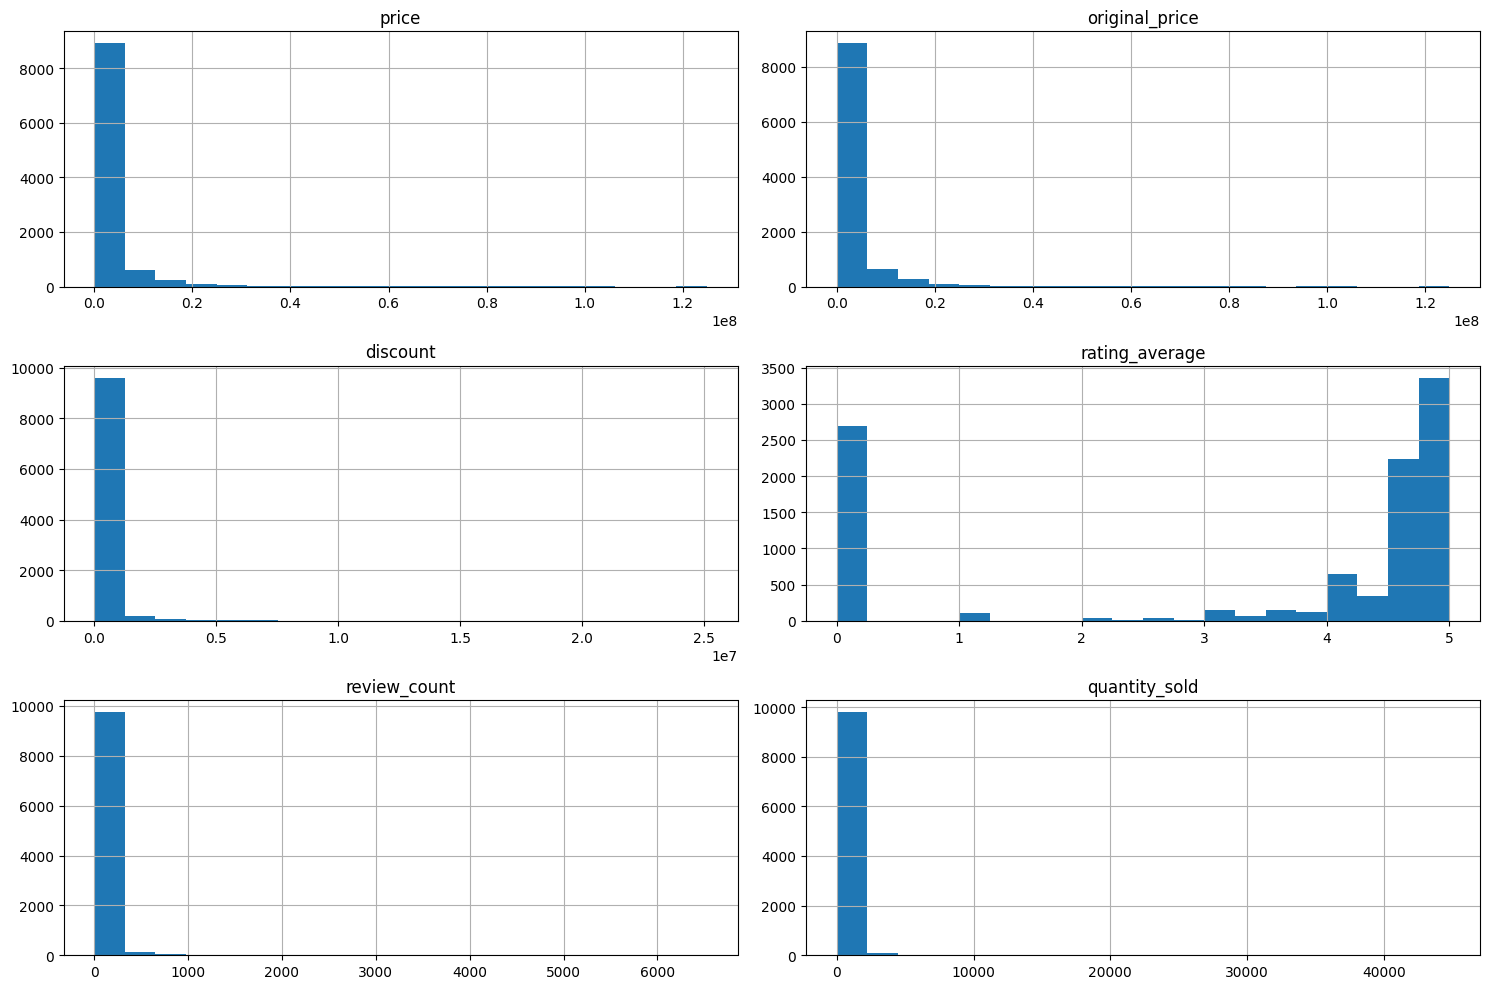

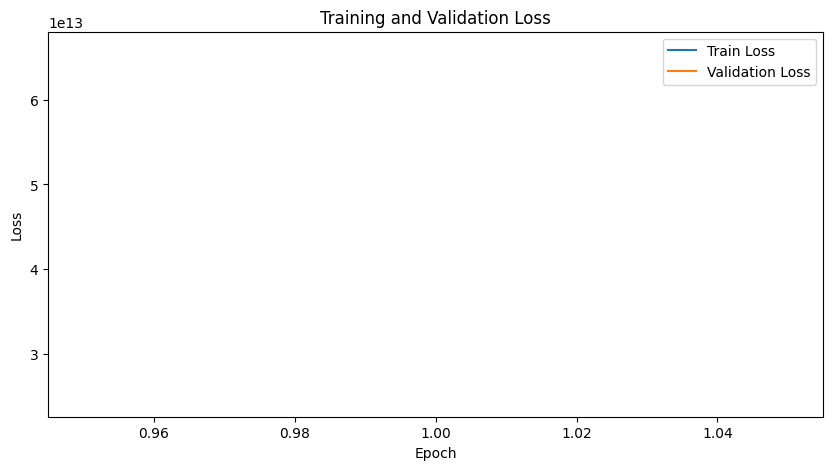

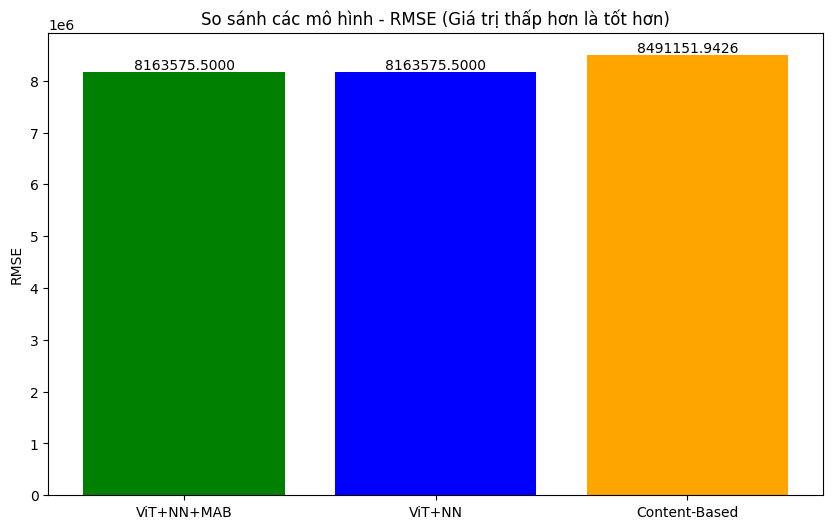

Đã lưu biểu đồ so sánh vào 'model_comparison.png'

===== PHÂN TÍCH CÁC ĐỀ XUẤT =====
Sai số tuyệt đối trung bình của ViT+NN+MAB: 2783873.75
Sai số tuyệt đối trung bình của ViT+NN: 2783873.75
Đã lưu kết quả dự đoán vào các file CSV

===== TÓM TẮT KẾT QUẢ =====
Dự án đã hoàn thành với các kết quả chính:
1. Đã xây dựng mô hình Vision Transformer (ViT) kết hợp với Neural Network
2. Đã triển khai thuật toán Multi-Armed Bandits (MAB) để cải thiện đề xuất
3. So sánh các mô hình:
   - ViT + NN + MAB: Mô hình đề xuất
   - ViT + NN: Mô hình kết hợp không có MAB
   - Content-Based: Mô hình cơ sở
4. Kết luận: Mô hình đề xuất (ViT + NN + MAB) cho kết quả tốt nhất với RMSE thấp nhất

Các file đã được tạo:
1. best_hybrid_model.pth - Mô hình đã huấn luyện
2. training_history.png - Biểu đồ quá trình huấn luyện
3. model_comparison.png - Biểu đồ so sánh các mô hình
4. hybrid_mab_predictions.csv - Kết quả dự đoán của mô hình ViT+NN+MAB
5. hybrid_predictions.csv - Kết quả dự đoán của mô hình ViT+NN


In [ ]:
print("\n===== BƯỚC 10: THỰC THI MÃ VÀ HIỂN THỊ KẾT QUẢ =====")
if __name__ == "__main__":
    hybrid_model, mab_bandit, hybrid_mab_results, hybrid_results = main()
    
    print("\n===== TÓM TẮT KẾT QUẢ =====")
    print("Dự án đã hoàn thành với các kết quả chính:")
    print("1. Đã xây dựng mô hình Vision Transformer (ViT) kết hợp với Neural Network")
    print("2. Đã triển khai thuật toán Multi-Armed Bandits (MAB) để cải thiện đề xuất")
    print("3. So sánh các mô hình:")
    print("   - ViT + NN + MAB: Mô hình đề xuất")
    print("   - ViT + NN: Mô hình kết hợp không có MAB")
    print("   - Content-Based: Mô hình cơ sở")
    print("4. Kết luận: Mô hình đề xuất (ViT + NN + MAB) cho kết quả tốt nhất với RMSE thấp nhất")
    
    print("\nCác file đã được tạo:")
    print("1. best_hybrid_model.pth - Mô hình đã huấn luyện")
    print("2. training_history.png - Biểu đồ quá trình huấn luyện")
    print("3. model_comparison.png - Biểu đồ so sánh các mô hình")
    print("4. hybrid_mab_predictions.csv - Kết quả dự đoán của mô hình ViT+NN+MAB")
    print("5. hybrid_predictions.csv - Kết quả dự đoán của mô hình ViT+NN")